In [71]:
"""
Exploratory data analysis for Treasure Valley NPDES data from various
sources.

19 July 2018
"""
# Conversions
# 1 MGD = 3.07 AF
import os
import sys
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
plt.style.use('bmh')
from ipyleaflet import Map, basemaps,basemap_to_tiles, CircleMarker, Marker, GeoJSON
#from bokeh.plotting import figure, show
#from bokeh.io import output_notebook
#output_notebook()
# Change workding directory
os.chdir(r'D:/TreasureValley/waterbudget')

In [102]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Treasure Valley Water Budget: Effluent Data
This workbook parses and aggregates effluent data collected for NPDES permits in the Treasure Valley. A majority of the permitees
are municipal waste water treatment plants and stormwater districts. The data sources evaluated here came from a variety of sources (in no particular order):
+ ACHD Records request for the MS4 stormwater district
+ NPDES data provided by Karen Burgess (EPA) retrieved from their DMR database, parameter code 50050
+ NPDES data downloaded from the EPA ECHO website. Only back through 2014, should request more from Karen
+ Boise Geothermal project data from Jon Gunnerson @ City of Boise

## Larger Municipal WWTPs from EPA
DMR data provided by Karen Burgess 

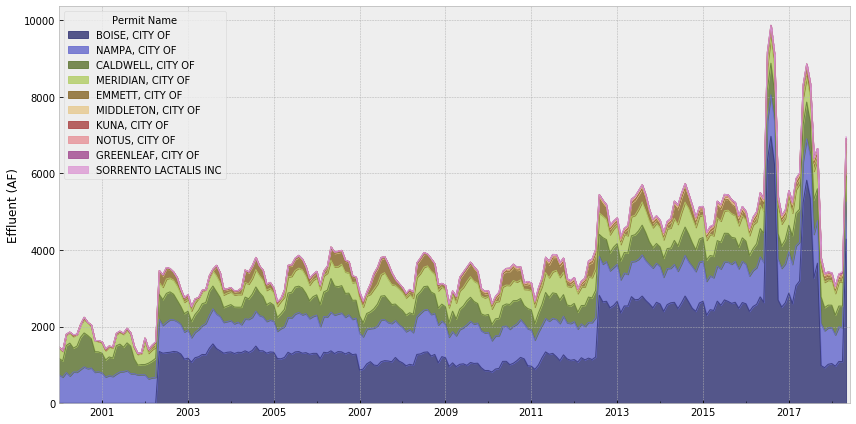

In [49]:
fid = r'./NPDES/DMR_Data_Request-DNR_6-21-18.xlsx'
df = pd.read_excel(fid, sheet_name='Report 1', header=0, 
              parse_dates = True, index_col=[15])
# ------------------------------------------------------------------------
# Extract only Effluent Gross rows from 'Limits.Monitoring Location Desc'
# Remove upstream monitoring data for Caldwell
# Remove extreme values 
df = df[ df['Limits.Monitoring Location Desc' ] == 'Effluent Gross' ]
df = df[ df['Statistical Base Short Desc'].str.contains('MO AVG')]
df['DMR Value'][df['DMR Value'] > 1000] = np.nan
# Describe 
dfgrouper = df.groupby(['Permit Name','NPDES ID','Perm Feature ID'])
SiteDictKeys = dfgrouper.groups.keys()
SiteList = [x for x in SiteDictKeys]
SiteDict = dict.fromkeys(SiteDictKeys)

dfstats = dfgrouper['DMR Value'].describe()

for site in SiteList:
    s = dfgrouper['DMR Value'].get_group(site)
    # Convert to AF per month
    s = s * s.index.days_in_month * 3.07
    s.name = site
    SiteDict[site] = s
    
# convert to data frame
temp=pd.concat(SiteDict.values(),keys=SiteDict.keys(),names=['Permit Name','NPDES ID','Perm Feature ID'])
temp = pd.DataFrame(temp)
a = temp.unstack(-1,fill_value=np.nan)
temp = pd.DataFrame(data = a.values.T,columns = a.index, index=pd.date_range(start='2000-1-1',end='2018-12-31',freq='M'))
temp.dropna(how='all', inplace=True)
df_DMR = temp
del temp

# Make some plots
sorted_cols = df_DMR.groupby(axis=1,level=0).sum().sum().sort_values(ascending=False).index
fig1 = df_DMR[sorted_cols].groupby(axis=1,level=0,sort=False).sum().plot(kind='area',cmap='tab20b',alpha=.85,linewidth=1,figsize=(12,6))
ax = fig1.axes
ax.set_xlim(360,581)
ax.set_ylabel('Effluent (AF)')
plt.tight_layout()


## Smaller effluent sources (EPA ECHO)
Some WWTP data was not provided in my last contact with the EPA, though data back to 2013 was available online

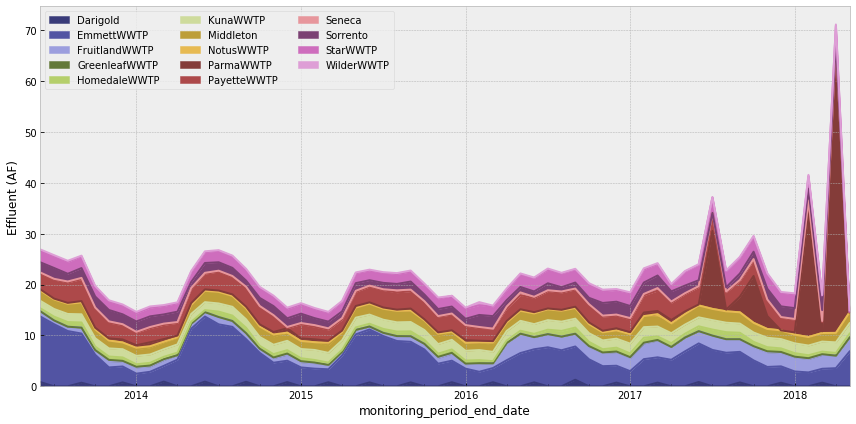

In [79]:
# ----------------------------------------------------
# 2. Smaller effluent sources not provided by EPA yet
# ----------------------------------------------------

# Load into dataframe          
for i,fpath in enumerate(glob(r'.\\NPDES\\*\\out*')):
    permit = fpath.split('\\')[3]
    if i == 0:
        data = pd.read_csv(fpath,header=0,
                           parse_dates = True,
                           infer_datetime_format = True)
        data['permit_name'] = permit
    else:
        temp = pd.read_csv(fpath, header= 0,
                           parse_dates = True,
                           infer_datetime_format = True)
        temp['permit_name'] = permit
        data = pd.concat([data,temp])
            
data = data[ data['monitoring_location_desc' ] == 'Effluent Gross' ]
data.index = data['monitoring_period_end_date'].astype(np.datetime64)
#df = df[ df['Statistical Base Short Desc'].str.contains('MO AVG')]
data['dmr_value_nmbr'][data['dmr_value_nmbr'] > 1000] = np.nan
grouper = data.groupby(['permit_name','npdes_id','statistical_base_short_desc'])
#grouper['dmr_value_nmbr'].size()
# Check stat codes for permits
  
for i,name in enumerate(grouper['dmr_value_nmbr']):
    if i == 0:
        temp = pd.DataFrame(data=name[1])
        temp.columns = pd.MultiIndex.from_tuples([name[0]],
                                                 names=['permit_name','npdes_id','stat'])
    else:
        temp2 = pd.DataFrame(data=name[1])
        temp2.columns = pd.MultiIndex.from_tuples([name[0]],
                                                 names=['permit_name','npdes_id','stat'])
        temp=temp.merge(temp2,how='outer',right_index=True,left_index=True)
            
    
dfNPDES = temp * 3.07
sorted_cols = dfNPDES.groupby(axis=1,level=0).min().sum().sort_values(ascending=False).index
dfNPDES = dfNPDES.loc[:,sorted_cols]
# Get boolean of smaller municipalities
small_idx=~dfNPDES.columns.get_level_values(0).str.contains('boise|meridian|cald',case=False)
del temp

# Plot
fig2 = dfNPDES.loc[:,small_idx].groupby(axis=1,level=0,sort=False).min().plot(kind='area',cmap='tab20b',figsize=(12,6))
ax = fig2.axes
ax.set_xlim(521,580)
ax.set_ylabel('Effluent (AF)')
plt.tight_layout()
plt.legend(ncol=3)
plt.show()
#plt.savefig()

## Combine EPA and ECHO dataframes,
Dropping common NPDES so we're not plotting duplicated data

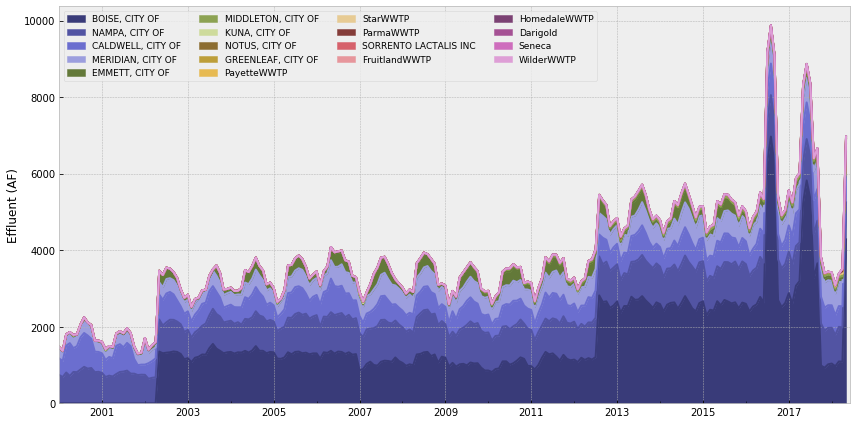

In [51]:
#-----------------------------------------
# 3. Combine dataframes, dropping common NPDES IDs
# ----------------------------------------
dropIDs = dfNPDES.columns.levels[1].isin(df_DMR.columns.levels[1])
dfNPDES.columns.levels[1][~dropIDs]
temp = dfNPDES.drop(level=1,labels=dfNPDES.columns.levels[1][dropIDs],axis=1)
ids = temp.T.index.get_level_values(1).unique()
ids=ids[ids != 'ID0021199']                        # Drop extraneous stats from this permit
temp=temp.groupby(axis=1,level=0,sort=False).min() # Extract minimum level to get one DMR value

# Make a multiindex so that join is happy
temp.columns = pd.MultiIndex.from_arrays([temp.columns,ids, np.array(['001'] * 8)])
a = df_DMR.join(temp) # Join
sorted_cols = a.groupby(axis=1,level=0).min().sum().sort_values(ascending=False).index
a = a[sorted_cols]

# Plot
fig3 = a.groupby(axis=1,level=0,sort=False).sum().plot(kind='area',cmap='tab20b',figsize=(12,6))
ax = fig3.axes
ax.set_xlim(360,581)
ax.set_ylabel('Effluent (AF)')
plt.tight_layout()
plt.legend(fontsize=9,ncol=4)

The big jumps are from the West Boise WWTP (2012) and the phosphorous removal facility (peaks after 2016). 

In [103]:
## Map effluent locations ( not yet implemented )

In [75]:
import geopandas
from shapely.geometry import Point
import re
# Get coordinates for mapping
SiteCoords = {}
for site in SiteList:
    dms2dd = lambda x: x[0] + x[1]/60 + x[2]/3600
    latstr = dfgrouper['Latitude in DMS'].get_group(site)[0]
    lat=dms2dd([int(x) for x in re.split('\'|\s|\'|\"',latstr) if x.isdigit()])
    lonstr = dfgrouper['Longitude in DMS'].get_group(site)[0]
    long = -dms2dd([int(x) for x in re.split('\'|\s|\'|\"',lonstr) if x.isdigit()])
    SiteCoords[site] = pd.Series([lat, long])

    
temp = pd.concat(SiteCoords.values(),keys=SiteCoords.keys(),axis=1).T
temp.columns = ['lat','long']
temp['geometry'] = temp.apply(lambda x: Point((float(x.lat), float(x.long))),axis=1)
temp = geopandas.GeoDataFrame(temp,geometry='geometry',crs = 'epsg:4326')


In [74]:
#m = Map( center = (43.65, -116.47), zoom = 9, basemap=basemaps.Esri.DeLorme)
#m

## Boise Geothermal: Permit ID0025488
Occassionaly discharges into the Boise River. Probably can be ignored, though seem to be longer periods of outfall into the Boise between 2005-2007. Need to ask Jon if this is real.

Data come in mean hourly GPM. Conversion is 

$ \sum\limits_{i=1}^N GPM_{avg,hr}^i \times 60 \frac{min}{hr} \times 0.1337 \frac{gal}{ft^3} \times \frac{1}{43560} \frac{acre}{ft^2}$ 

In [120]:
# concatenate a few separate files. 2009 - present
d = {}
for i,f in enumerate(glob('.\\NPDES\\*\\Inj*')):
    df = pd.read_excel( f, sheet_name='Data',
                       header=19, usecols=[0,4], index_col=0,
                       parse_dates=True, infer_datetime_format=True)
    d[i] = df
    
df = pd.concat(d.values())
df.sort_index(inplace=True)   
df = df.squeeze()
df[df < 1] = 0

d2={}
for i,f in enumerate(glob('.\\NPDES\\*\\DMS\\*xls')):
    # The pandas parser doesnt like these old excel files. Go a little lower level
    
    try:
        xls = pd.ExcelFile(f)
    except:
        print('Failed to read {}, corrupt'.format(f))
    
    else:
        data = xls.parse(sheet_name='Sheet1',header=None,na_values=['Null','#N/A','-'])
        xls.close()
        data = data.dropna(how='all').reset_index(drop=True)
        # Find header by searching for DateTime
        hline = (data == 'DateTime').any(axis=1).nonzero()[0][0]
        # Find column by looking for Flow
        col = (data.iloc[hline,:] == 'RTU39_FLOW').nonzero()[0][0]
        s = pd.Series(data = data.iloc[hline+1:,col].values, 
                       index = pd.to_datetime(data.iloc[hline+1:,0], errors='coerce'),
                       dtype=float)
        
        label = np.array(f.split('\\')[-1].split('-')[0:3]).astype(int)
        label =pd.datetime(label[2],label[0],label[1]).date()
        d2[label] = s
   
df2 = pd.concat(d2.values())
df2.sort_index(inplace=True)
df2.name = 'RTU39_FLOW'
    

Failed to read .\NPDES\BoiseGeothermal\DMS\11-30-2005 - MONTHLY SCADA DATA -  -.xls, corrupt
Failed to read .\NPDES\BoiseGeothermal\DMS\12-30-2005 - MONTHLY SCADA DATA -  -.xls, corrupt


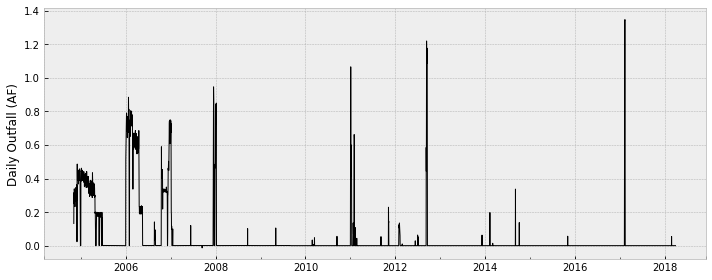

In [121]:
df3 = pd.concat([df,df2]).sort_index()
df3 = df3[~df3.index.duplicated(keep='first')]
dfGEO = df3.resample('D').apply(lambda x: np.nansum(x) * 60 * .1337 / 43560)
dfGEO.plot(c='k',linewidth=1,figsize=(10,4))
plt.ylabel('Daily Outfall (AF)')
plt.tight_layout()

## Boise Area MS4*
*Municipal Separate Stormwater Sewer System

Some monitoring occured around 2011, then again from 2014-present. These data are on subwatershed scale, all of which are < 1000 acres.

### First Phase of Monitoring (2010-2011)
![title](./NPDES/ACHD/PhaseIsites.png)

In [114]:
# Stormwater data helper functions
def PlotFs( df , title = None ):
    ''' Make a gant plot of time variable time steps in the data'''
    # Gant Plot of timestamps
    delt = df.index.to_series().diff().dropna().apply(lambda x:pd.Timedelta.total_seconds(x)/60)
    delt[delt > 120] = np.nan
    delt=delt.dropna()
    y = delt.unique()
    y.sort()
    
    color = plt.cm.cubehelix(np.linspace(0,1,30))
    colordict = dict(zip(y,color))
    # Start iterating through values. If they are the same, skip, if it is different,
    # plot a line
    # Initiate first timestamp
    fig,ax=plt.subplots(1,1)
    x1 = delt.index[0]
    for i in range(len(delt)):
        if delt[i] != delt[x1]:
            c = colordict[delt[i-1]]
            x2 = delt.index[i-1]  
            plt.hlines(delt[x1], x1, x2, color = c, linewidth=5)
            x1 = delt.index[i]        
    
    ax.set_ylabel('Sampling Frequency',fontsize=10)
    
    if title:
        ax.set_title(title,fontsize=10)
    plt.yticks([1,15,30,60],['1 min','15 min','30 min','60 min']) 
    ax.set_ylim(0,70)    
    plt.tight_layout()
            
    return fig

def df2csv_head(df,fprefix='data',units=None):
    ''' Write dataframe with some metadata to cwd '''
   
    outpath = '{}_{}_{}.csv'.format( fprefix, \
               df.first_valid_index().strftime('%Y%m%d'),\
               df.last_valid_index().strftime('%Y%m%d') )
    if df.index.freq:
        outpath = outpath.replace(fprefix,'{}_{}'.format(fprefix,df.index.freqstr))
    outpath = outpath.replace(' ','_')
    
    meta = pd.Series([
            ('{}'.format(fprefix)),
            ('date generated: {0}'.format(pd.datetime.now().strftime('%d %b %Y @ %H%M'))),
            ('by: {}'.format(os.environ.get("USERNAME"))),
            ('units: {}'.format(units)),
            ])
    
    with open(outpath , 'w') as fout:
        meta.to_csv(fout, index=False)
        df.to_csv(fout,float_format='%4.3f')
    

In [82]:
#-------------------------------
# 5. ACHD Stormflow Phase 1
# --------------------------------
import xlrd
getsheets = False
cfs2cfd = lambda x: np.nansum(x)*60*60
#  Path to early Phase 1 flow data
f = r'D:/TreasureValley/waterbudget/NPDES/ACHD/2011 Phase I Flow.xlsx'

if getsheets:
    with xlrd.open_workbook(f) as wb:
        sheets = wb.sheet_names()
else:
    sheets = ['Walnut', 'Franklin', 'Production', 'Lucky', 
              'Walnut Alt', 'Koppels']
    
for i,sheet in enumerate(sheets):
    print('Parsing {}'.format(sheet))
    df = pd.read_excel(f, sheet_name=sheet,header=2,
                       parse_dates=[[0,1]],index_col=0,infer_datetime_format=True)
    # Remove bad data
     # These conditionals describe values we wish to keep
    idx = \
    ( df['Vel (fps)'] > df['Velocity Cutoff (cfs)']) | \
    ( df['Velocity Cutoff (cfs)'].isnull() )              & \
    ( df['Vel (fps)'] >= 0.)                             & \
    ( df['Flow (cfs)'] >= 0.0 )
    df = df.where(idx, np.nan)
    #df['Flow (cfs)'] = df['Flow (cfs)'].where(df['Flow (cfs)'] > 0.00,0)
    #df = df.where(df['Vel (fps)'] >= 0.00,np.nan)
    
 
    # Check frequency. If in minutes, resample to hour
    freq_inf = df.index.to_series().diff().min()
    print('    Detected a frequency of {}'.format(freq_inf) )
    if freq_inf.seconds == 60:
        print('    Resampling to hourly data with hourly means')
        df = df.resample('H').mean()        
        
    # CFS -> CFH -> AFD
    if i ==0:
        s=df['Flow (cfs)'].resample('D').apply(cfs2cfd )
        dfAF = pd.DataFrame(s)
        dfAF.columns = [sheet]
    else:
        temp = df['Flow (cfs)'].resample('D').apply(cfs2cfd)
        temp.name = sheet
        dfAF = dfAF.join(temp,how='outer')
  

Parsing Walnut
    Detected a frequency of 0 days 01:00:00
Parsing Franklin
    Detected a frequency of 0 days 01:00:00
Parsing Production
    Detected a frequency of 0 days 00:01:00
    Resampling to hourly data with hourly means
Parsing Lucky
    Detected a frequency of 0 days 00:01:00
    Resampling to hourly data with hourly means
Parsing Walnut Alt
    Detected a frequency of 0 days 00:01:00
    Resampling to hourly data with hourly means
Parsing Koppels
    Detected a frequency of 0 days 00:01:00
    Resampling to hourly data with hourly means


Plot daily flows and monthly sums across all sites in cubic feet. I'm keeping this unit so we can compare to the Brown and Caldwell Reports

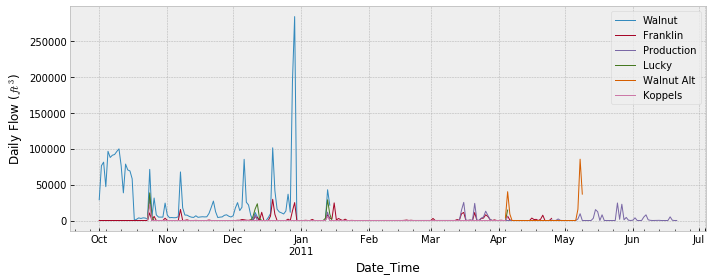

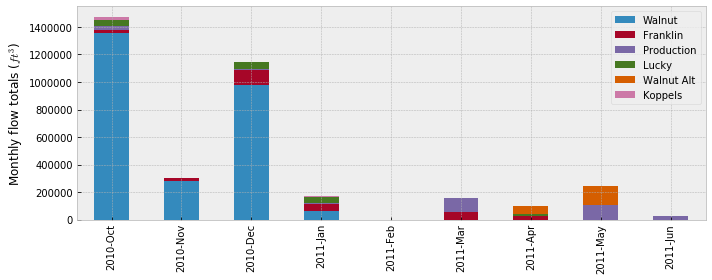

In [104]:
# Plot 
fig4,ax4 = plt.subplots(1,1)
dfAF.plot(linewidth=1,ax =ax4,figsize=(10,4))
ax4.set_ylabel('Daily Flow ($ft^3$)')
fig4.tight_layout()

dfM=dfAF.resample('M').sum()
fig5, ax5 = plt.subplots(1,1,figsize=(10,4))
dfM.plot(kind='bar',ax=ax5,stacked=True,sort_columns=True)
ax5.set_xticklabels(dfM.index.strftime('%Y-%b'))
ax5.set_xlabel('')
ax5.set_ylabel('Monthly flow totals ($ft^3$)')
fig5.tight_layout()

#Write File
#dfAF = dfAF.resample('D').asfreq()
#df2csv_head(dfAF,fprefix='Stormwater_ACHD',units='ft^3')

### Second phase of monitoring
![title](./NPDES/ACHD/PhaseIIsites.png)

Something to be aware of is the cornucopia of sampling frequencies in the data. Once we parse in the data, a plot of the frequencies will be shown for Whitewater

Parsing Americana Alternate Flow from .\NPDES\ACHD\Americana Alternate Flow.csv
Parsing Americana Flow from .\NPDES\ACHD\Americana Flow.csv
Parsing Franklin Flow from .\NPDES\ACHD\Franklin Flow.csv
Parsing Koppels Alternate Flow from .\NPDES\ACHD\Koppels Alternate Flow.csv
Parsing Lucky Flow from .\NPDES\ACHD\Lucky Flow.csv
Parsing Main Alternate Flow from .\NPDES\ACHD\Main Alternate Flow.csv
Parsing Main Flow from .\NPDES\ACHD\Main Flow.csv
Parsing Stilson Flow from .\NPDES\ACHD\Stilson Flow.csv
Parsing Whitewater Flow from .\NPDES\ACHD\Whitewater Flow.csv


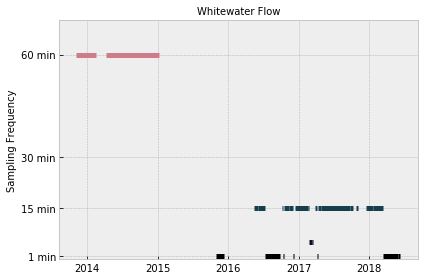

In [87]:
for i,f in enumerate(glob('.\\NPDES\\ACHD\\*Flow.csv')):
    
    site =  f.split('\\')[-1].replace('.csv','')
    print('Parsing {} from {}'.format(site,f))
        
    df = pd.read_csv(f,header=0,parse_dates=[[1,2]]) 
    df.set_index(keys='Date_Time',drop=True,inplace=True)
    if site == 'Whitewater Flow':
        fig6 = PlotFs(df,site)
    # Some comments exist in the cutoff column
    df['Velocity_Cutoff_950(fps)']=pd.to_numeric(df['Velocity_Cutoff_950(fps)'],errors='coerce')
    
    # These conditionals describe values we wish to keep
    idx = \
    ( df['Velocity(fps)'] > df['Velocity_Cutoff_950(fps)']) | \
    ( df['Velocity_Cutoff_950(fps)'].isnull() )              & \
    ( df['Velocity(fps)'] >= 0.)                             & \
    ( df['Flow(cfs)'] >= 0.0 )
    
    df = df.where(idx, np.nan)
    # Upsample to minutes to get all timesteps at the same level
    # Mean CFS per minute
    df = df['Flow(cfs)'].resample('1T').asfreq()
    df = df.resample('H').mean() # Hourly mean to get on the same fotting
    if i == 0:
        s=df.resample('D').apply(cfs2cfd)
        dfAF2 = pd.DataFrame(s)
        dfAF2.columns = [site]
    else:
        temp = df.resample('D').apply(cfs2cfd)
        temp.name = site
        dfAF2 = dfAF2.join(temp,how='outer') 
        # Check frequency. If in minutes, resample to hour
        df.index.to_series().diff().dropna().apply(lambda x:pd.Timedelta.total_seconds(x))
        #freq_inf = df.index.to_series().diff().max()
        #print('    Detected a frequency of {}'.format(freq_inf) )

dfAF2=dfAF2.resample('D').asfreq()
dfAF2 = dfAF2['2013-10-1':].dropna(how='all',axis=1)

# Select some dates for comparing with the NPDES Phase I B&C report(pg.37,Table 5)
dfAF2summary = pd.concat([dfAF2.loc['2016-12-4'],dfAF2.loc['2017-2-16'],dfAF2.loc['2017-3-24'],dfAF2.loc['2017-4-24'],dfAF2.loc['2017-5-16']],axis=1)    

Compare my volumes with Brown and Caldwell's reported volumes in the NPDES Phase I Monitoring Report( Table 5, p.37)

![title](./NPDES/ACHD/StormFlowTable.png)

In [99]:
dfAF2summary.apply(round).T

,Americana Alternate Flow,Americana Flow,Lucky Flow,Main Alternate Flow,Main Flow,Stilson Flow,Whitewater Flow
2016-12-04,NaN,47004.0,5461.0,NaN,7326.0,3268.0,14529.0
2017-02-16,NaN,72360.0,1232.0,NaN,6416.0,4028.0,34767.0
2017-03-24,112270.0,112270.0,11714.0,5255.0,0.0,7961.0,58919.0
2017-04-24,236234.0,236234.0,31090.0,12756.0,0.0,16490.0,71713.0
2017-05-16,291784.0,291784.0,26422.0,26587.0,0.0,0.0,0.0


+ Lucky matches about half of the storms flow.
+ Whitewater doesn't really match any
+ Main is pretty close for all storms
+ Stilson is close on 3 of 4 storms
+ Americana misses the mark on all storms

Estimates are both over and under. Maybe taking the hourly mean when resampling to daily flows is skewing the results. Also, I am looking only at full days in my table and haven't done a storm-by-storm analysis, so overnight storms or runoff occuring past what Brown and Caldwell define as the storm period could account for differences in the flow summations.

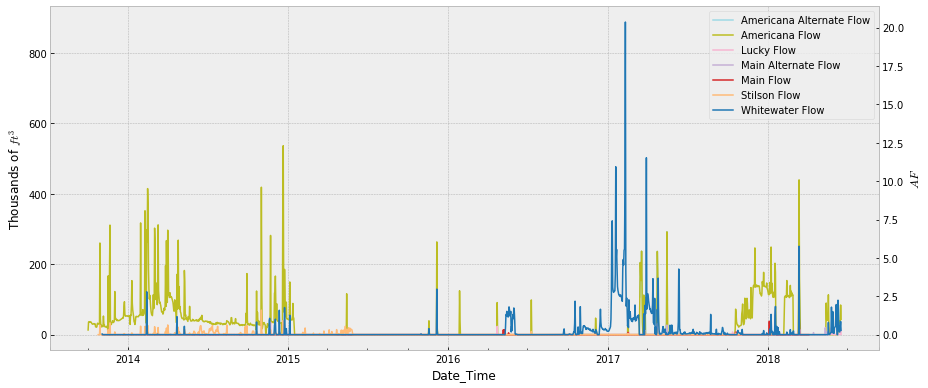

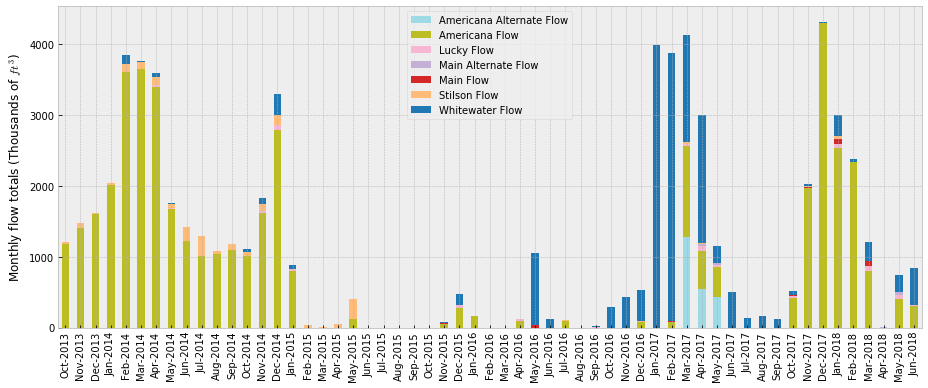

In [113]:
# PLOT IT
fig7,ax7 = plt.subplots(1,1,figsize=(13,5.5))    
dfAF2['2013-10-1':].div(1000).plot(ax=ax7,cmap='tab20_r',linewidth=1.5)
# Add second y scale for acre-ft
ax7t = ax7.twinx()
dfAF2['2013-10-1':].div(43560).plot(alpha=0,ax=ax7t,legend=False)
ax7t.grid()
ax7t.set_ylabel(r'$AF$')
ax7.set_ylabel(r'Thousands of $ft^3$')
fig7.tight_layout()

fig8, ax8 = plt.subplots(1,1,figsize=(13,5.5))
dfAF2.resample('M').sum().div(1000).plot(kind='bar',ax=ax8,stacked=True,sort_columns=True,cmap='tab20_r')
ax8.set_xticklabels(dfAF2.resample('M').sum().index.strftime('%b-%Y'))
ax8.set_xlabel('')
ax8.set_ylabel('Monthly flow totals (Thousands of $ft^3$)')
fig8.tight_layout()

In [125]:
# Write some dataframes from above
# NPDES
df2csv_head(a.resample('M').asfreq(),
            fprefix='NPDES_combined',units='acre-ft')
# Geothermal Project
df2csv_head(dfGEO.resample('D').asfreq(),
           fprefix='Boise_geothermal',
           units='acre-ft')